In [1]:
# https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/simple_autoencoder.py

In [30]:
__author__ = 'SherlockLiao'

import os

import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

device = torch.device("mps")

In [3]:
if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


num_epochs = 50
batch_size = 128
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MNIST('./data', transform=img_transform, download=False)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=True)


class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            # use 3 latents
            nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28),
            # to allow for negative values in the output img
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
# model = autoencoder().to(device)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     model.parameters(), lr=learning_rate, weight_decay=1e-5)
# 
# for epoch in range(num_epochs):
#     for data in dataloader:
#         img, _ = data
#         img = img.view(img.size(0), -1)
#         img = Variable(img).to(device)
#         # ===================forward=====================
#         output = model(img)
#         loss = criterion(output, img)
#         # ===================backward====================
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     # ===================log========================
#     print(loss.data)
#     print('epoch [{}/{}], loss:{:.4f}'
#           .format(epoch + 1, num_epochs, loss.data))
#     if epoch % 10 == 0:
#         pic = to_img(output.cpu().data)
#         save_image(pic, './mlp_img/image_{}.png'.format(epoch))
# 
# torch.save(model.state_dict(), './sim_autoencoder.pth')

In [5]:
import pickle
with open("autoenc.pickle", 'rb') as f:
    model = pickle.load(f)
#with open("autoenc.pickle", 'wb') as f:
#    pickle.dump(model, f)

# look at latents

In [6]:
# img = img.view(img.size(0), -1)
# img = Variable(img).to(device)
# plt.imshow(to_img(model(img).cpu().data)[0][0,:,:])

In [22]:
# get the latents
ls = []
i = 0
print(i-1)
for data in dataloader: # iterate over the batches
    # it runs asynchronously, so print statements don't work
    print(i)
    if i > 20: break
    img, _ = data
    # this is required to avoid locking up the dataloader
    # I think it may have been trying to run on the CPU
    # when I didn't load the data properly into the device
    # or something
    img = img.view(img.size(0), -1)
    img = Variable(img).to(device)
    ls.extend(model.encoder(img).cpu().detach().numpy()) # latents
    i = i + 1

-1
0
1
2
3
4
5
6
7
8
9
10
11


In [23]:
import numpy as np
# convert to array
ls = np.array(ls)
ls.shape

(1408, 3)

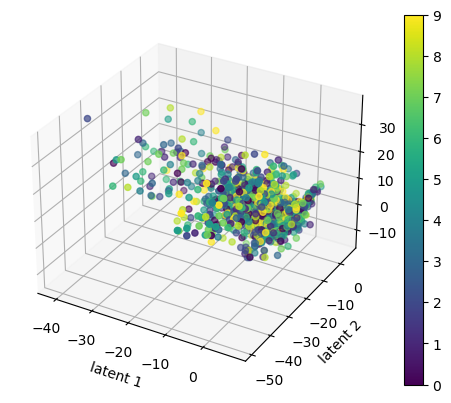

In [36]:
# there are 3 latents, let's plot them
#print(model(img).cpu().data.shape)
#print(model.encoder(img).shape)
#ls = model.encoder(img).cpu().detach().numpy() # latents
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scat = ax.scatter(ls[:,0], ls[:,1], ls[:,2],
                  #cmap=colors.Colormap('jet'),
                  c=dataset.targets[:len(ls)])
ax.set_xlabel('latent 1')
ax.set_ylabel('latent 2')
ax.set_zlabel('latent 3')
plt.colorbar(scat) # show the colorbar (like a legend, but for colors)
plt.show()

(1408, 2)


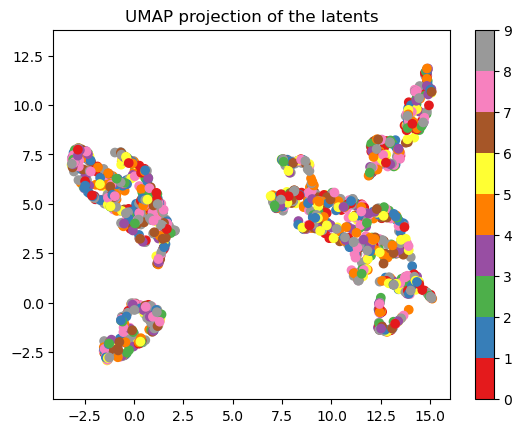

In [45]:
from sklearn.preprocessing import StandardScaler
import umap

reducer = umap.UMAP()
scaled_latents = StandardScaler().fit_transform(ls)

embedding = reducer.fit_transform(scaled_latents)
print(embedding.shape)

scat = plt.scatter(
    embedding[:,0],
    embedding[:,1],
    cmap=plt.get_cmap('Set1'),
    c=dataset.targets[:len(ls)])
plt.colorbar(scat) # show the colorbar (like a legend, but for colors)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the latents');

# cool, the latents cluster into interesting globs,
# but the digits are mixed, which is weird